In [1]:
from utils import *
from extraction import *
import tensorflow as tf
from matplotlib.colors import ListedColormap

2024-03-17 14:16:47.643630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 14:16:47.643686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 14:16:47.644632: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 14:16:47.650999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 14:16:48.383641: W tensorflow/compiler/tf2

In [2]:
if not os.path.exists(MASK_TESTING_DIR):
    os.makedirs(MASK_TESTING_DIR)
if not os.path.exists(MASK_TRAINING_DIR):
    os.makedirs(MASK_TRAINING_DIR)

In [3]:
model = tf.keras.models.load_model(MODEL_PATH)

2024-03-17 14:16:54.308376: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 14:16:54.553550: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 14:16:54.553615: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 14:16:54.556397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-17 14:16:54.556453: I external/local_xla/xla/stream_executor

In [4]:
def standardise(array_4d):
    num_classes = array_4d.shape[3]
    quantized_data = np.empty(array_4d.shape, dtype=np.int8)
    for class_idx in range(num_classes):
        class_data = array_4d[:, :, :, class_idx]
        class_data = np.round(class_data)
        quantized_data[:, :, :, class_idx] = class_data.astype(np.int8)
    return np.argmax(quantized_data, axis=-1)

In [5]:
for i in range(1, PT_NUM+1):
    ptnum = str(i).zfill(3)
    save_path = os.path.join(MASK_TRAINING_DIR, f"patient{ptnum}_gt.nii")
    if os.path.exists(save_path):
        continue;
    img = nib_from_int(i)
    total_frames = training_data_DF.loc[i-1,'NbFrame']
    all_frames = []
    for j in range(int(total_frames)):
        frame = img.get_fdata()[:,:,:,j]
        frame = img4d_extraction(nib.Nifti1Image(frame, img.affine), CROP_SIZE)
        frame = np.expand_dims(frame, axis=0)
        img_mask = model.predict(frame)
        img_mask = img_mask[0,:,:,:,:]
        img_mask = standardise(img_mask)
        all_frames.append(img_mask)
    all_frames = np.transpose(np.asarray(all_frames), axes=(1, 2, 3, 0))
    affine = np.diag([1.25, 1.25, 10.0, 1.0])
    nifti_mask = nib.Nifti1Image(all_frames, affine=affine, dtype=np.int8)
    nib.save(nifti_mask, save_path)

2024-03-17 14:17:18.501775: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-17 14:17:18.732728: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-17 14:17:23.959321: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-17 14:17:24.126275: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.99GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-17 14:17:24.480258: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran o

1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: 

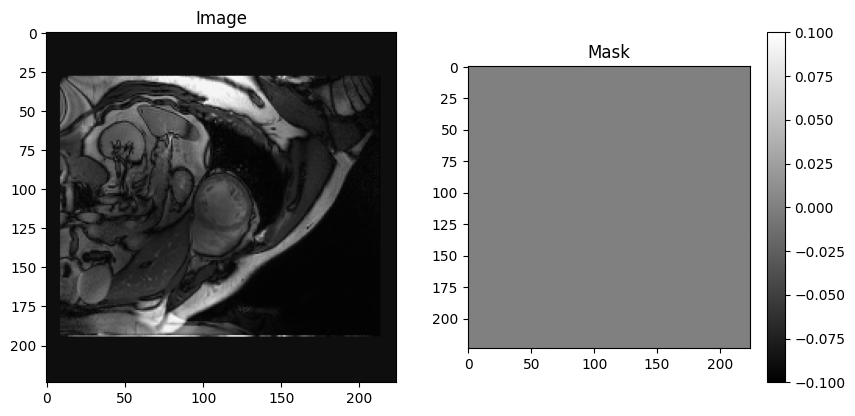

In [10]:
num_pt = 15
mask_4d = load_mask(num_pt).get_fdata()

mask_img = nib_from_int(num_pt)
mask_img_data = mask_img.get_fdata()[:,:,:,5]
mask_img_data = img4d_extraction(nib.Nifti1Image(mask_img_data, mask_img.affine), CROP_SIZE)

plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(mask_img_data[:,:,5], cmap='gray')
plt.title("Image")
plt.subplot(2,2,2)
plt.imshow(mask_4d[:,:,5,5], cmap = 'gray')
plt.title("Mask")
plt.colorbar()
plt.show()

In [ ]:
for i in range(PT_NUM+1, PT_NUM+TEST_PT_NUM+1):
    ptnum = str(i).zfill(3)
    save_path = os.path.join(MASK_TESTING_DIR, f"patient{ptnum}_gt.nii")
    if os.path.exists(save_path):
        continue;
    img = nib_from_int(i,testing=True)
    total_frames = testing_data_DF.loc[i-PT_NUM-1,'NbFrame']
    all_frames = []
    for j in range(int(total_frames)):
        frame = img.get_fdata()[:,:,:,j]
        frame = img4d_extraction(nib.Nifti1Image(frame, img.affine), CROP_SIZE)
        frame = np.expand_dims(frame, axis=0)
        img_mask = model.predict(frame)
        img_mask = img_mask[0,:,:,:,:]
        img_mask = standardise(img_mask)
        all_frames.append(img_mask)
    all_frames = np.transpose(np.asarray(all_frames), axes=(1, 2, 3, 0))
    affine = np.diag([1.25, 1.25, 10.0, 1.0])
    nifti_mask = nib.Nifti1Image(all_frames, affine=affine, dtype=np.int8)
    nib.save(nifti_mask, save_path)